In [1]:
from tensorflow.keras import datasets, layers, models, backend as K

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
(x, y), (x_t, y_t) = datasets.mnist.load_data()
x = x / 255.0
x_t = x_t / 255.0

x = np.expand_dims(x, axis=-1)
x_t = np.expand_dims(x_t, axis=-1)

# Exploring Rig2DConv layer

In [3]:
filters = 1
un_rotate = True
phi = 16
pad = 'SAME'
kernel_size = 10
ks = tf.constant(kernel_size, dtype='float32')
angle = tf.constant(0, dtype='float32')
angle2 = tf.constant(360, dtype='float32')
ang = tf.linspace(angle, angle2, phi+1)
mid = tf.constant(0.5, dtype='float32')
rds = tf.constant(np.pi / 180, dtype='float32')
center = tf.round((ks * mid) - mid)
# image
img = x[0]

In [4]:
_l = tf.ones(shape=filters)*0.5111867
alpha = tf.ones(shape=filters)*0.5651333
beta = tf.ones(shape=filters)*1.4184482

nf = 1
width = 28
height = 28

In [5]:
d = tf.range(ks)
x_coord, y_coord = tf.meshgrid(d, d)
x_coord = tf.cast(x_coord, dtype='float32') - center
y_coord = tf.cast(y_coord, dtype='float32') - center

In [6]:
# Horizontal basis filter
arx = tf.math.divide((-2 * alpha * tf.square(_l) * x_coord), np.pi) * tf.exp(-_l * ((alpha * tf.square(x_coord)) + (beta * tf.square(y_coord))))
# Vertical basis filter
ary = tf.math.divide((-2 * beta * tf.square(_l) * x_coord), np.pi) * tf.exp(-_l * ((alpha * tf.square(x_coord)) + (beta * tf.square(y_coord))))

Text(0.5, 1.0, 'arY')

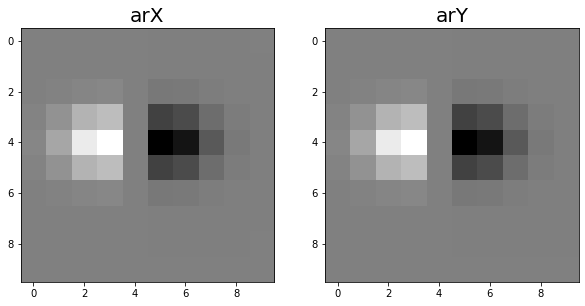

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(arx, cmap=plt.cm.binary_r)
plt.title('arX', fontdict={'size':20})
plt.subplot(1, 2, 2)
plt.imshow(ary, cmap=plt.cm.binary_r)
plt.title('arY', fontdict={'size':20})

In [8]:
arx = tf.expand_dims(arx, axis=-1)
ary = tf.expand_dims(ary, axis=-1)

In [9]:
# First filter generation
ar = (tf.cos(ang[0] * rds) * arx) + (tf.sin(ang[0] * rds) * ary)
# Convolve with first generated filter
par1 = tf.nn.conv2d(np.expand_dims(img, 0), tf.reshape(ar, (ks, ks, nf, 1)), strides=(1, 1, 1, 1), padding=pad)
# Rotation compensation to get translational feature space
par2 = tfa.image.rotate(par1, ang[0] * rds, interpolation='BILINEAR')

Text(0.5, 1.0, 'par2')

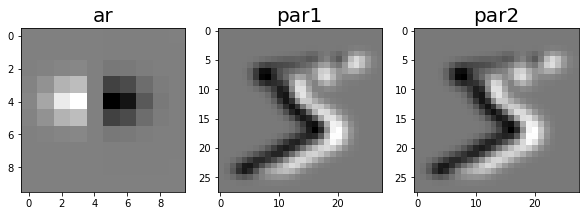

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(ar, cmap=plt.cm.binary_r)
plt.title('ar', fontdict={'size':20})
plt.subplot(1, 3, 2)
plt.imshow(par1[0], cmap=plt.cm.binary_r)
plt.title('par1', fontdict={'size':20})
plt.subplot(1, 3, 3)
plt.imshow(par2[0], cmap=plt.cm.binary_r)
plt.title('par2', fontdict={'size':20})

In [11]:
# Second filter generation
ar1 = (tf.cos(ang[1] * rds) * arx) + (tf.sin(ang[1] * rds) * ary)
# Convolve with second generated filter
par3 = tf.nn.conv2d(np.expand_dims(img, 0), tf.reshape(ar, (ks, ks, nf, 1)), strides=(1, 1, 1, 1), padding=pad)
# Rotation compensation to get translational feature space
par4 = tfa.image.rotate(par3, ang[1] * rds, interpolation='BILINEAR')

Text(0.5, 1.0, 'par4')

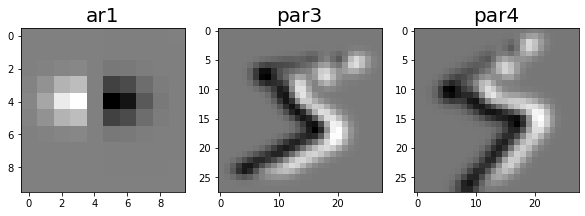

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.imshow(ar1, cmap=plt.cm.binary_r)
plt.title('ar1', fontdict={'size':20})
plt.subplot(1, 3, 2)
plt.imshow(par3[0], cmap=plt.cm.binary_r)
plt.title('par3', fontdict={'size':20})
plt.subplot(1, 3, 3)
plt.imshow(par4[0], cmap=plt.cm.binary_r)
plt.title('par4', fontdict={'size':20})

In [13]:
if un_rotate:
    out = tf.concat([par2, par4], axis=3)
else:
    out = tf.concat([par1, par3], axis=3)
out.shape

TensorShape([1, 28, 28, 2])

In [15]:
for aa in range(2, phi):
            ar = (tf.cos(ang[aa] * rds) * arx) + (tf.sin(ang[aa] * rds) * ary)
            partial = tf.nn.conv2d(np.expand_dims(img, 0), tf.reshape(ar, (ks, ks, nf, 1)), strides=(1, 1, 1, 1),
                                   padding=pad)
            partial2 = tfa.image.rotate(partial, ang[aa] * rds, interpolation='BILINEAR')
            if un_rotate:
                out = tf.concat([out, partial2], axis=3)
            else:
                out = tf.concat([out, partial], axis=3)

In [16]:
out_f1 = tf.reshape(out, shape=(-1, height, width, phi, 1))
out_f1_e = tf.transpose(out_f1, perm=(0, 3, 1, 2, 4))
out.shape, out_f1.shape, out_f1_e.shape

(TensorShape([1, 28, 28, 16]),
 TensorShape([1, 28, 28, 16, 1]),
 TensorShape([1, 16, 28, 28, 1]))

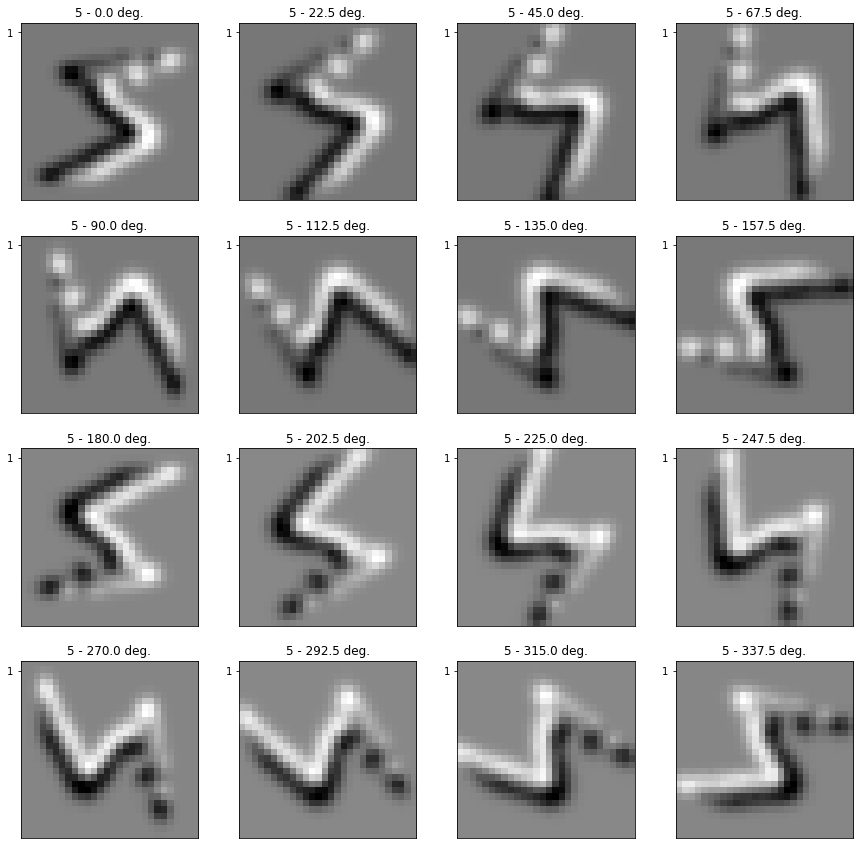

In [36]:
plt.figure(figsize=(15, 15))
for i in range(phi):
    plt.subplot(4, 4, i+1)
    plt.title(f'5 - {ang[i]} deg.')
    plt.xticks([])
    plt.yticks([1])
    plt.imshow(out[0,:,:,i], cmap=plt.cm.binary_r)

# Exploring Periodic_pad layer

In [42]:
# A cyclic convolution can be implemented with a linear convolution over a periodically padded feature space
inputs_to_layer = out_f1_e
x = tf.concat([inputs_to_layer, inputs_to_layer], axis=1)
inputs_to_layer.shape, x.shape

(TensorShape([1, 16, 28, 28, 1]), TensorShape([1, 32, 28, 28, 1]))

In [41]:
# last is not needed three times, thefore remove last
x[:, :-1, :, : ,:].shape

TensorShape([1, 31, 28, 28, 1])